In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 62 kB/s 
     |████████████████████████████████| 199 kB 94.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=1cfe0d4b4c103e644fbd432b724455c5bb799b2e0a277ba7d2e81663828baad3
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
#Imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
import json
import numpy as np
from pandas.api.types import is_string_dtype
import os
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
%matplotlib inline
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import warnings
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
import statsmodels.api as sm
import re
# Multi-processing
from multiprocessing import Pool, cpu_count
# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
# Process bar
from tqdm import tqdm
# Tracking time
from time import time

In [ ]:
!pip install download

In [ ]:
import os
!pip install prophet

In [ ]:
#from download import download
import plotly.express as px

In [ ]:
from prophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
indentity=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/identifiers.csv')

In [ ]:
def get_data(link):
    cy2020_json = requests.get(link)
    cy2020_recs = json.loads(cy2020_json.text)
    df = pd.DataFrame(cy2020_recs)
    return df

In [ ]:
monthly2020=get_data('https://data.cityofnewyork.us/resource/in83-58q5.json?$limit=5000000')
monthly2019=get_data('https://data.cityofnewyork.us/resource/evu4-6zyr.json?$limit=5000000')
monthly2018=get_data('https://data.cityofnewyork.us/resource/njuk-taxk.json?$limit=5000000')

In [ ]:
mon2020=monthly2020.copy()
mon2020.replace('Not Available',np.nan,inplace=True)
mon2020.replace("Insufficient access",np.nan,inplace=True)

In [ ]:
mon2020.head()

,property_id,property_name,parent_property_id,parent_property_name,month,electricity_use_kbtu,natural_gas_use_kbtu
0,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,Jan-20,2175731.1,NaN
1,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,Feb-20,1902208.9,NaN
2,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,Mar-20,1847793.7,NaN
3,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,Apr-20,1613573.0,NaN
4,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,May-20,1747078.0,NaN


In [ ]:
mon2019=monthly2019.copy()
mon2019.replace('Not Available',np.nan,inplace=True)
mon2019.replace("Insufficient access",np.nan,inplace=True)

In [ ]:
mon2018=monthly2018.copy()
mon2018.replace('Not Available',np.nan,inplace=True)
mon2018.replace("Insufficient access",np.nan,inplace=True)

In [ ]:
mon2020['electricity_use_kbtu'] = pd.to_numeric(mon2020['electricity_use_kbtu'], errors='ignore')
mon2020['natural_gas_use_kbtu'] = pd.to_numeric(mon2020['natural_gas_use_kbtu'], errors='ignore')
mon2019['electricity_use_kbtu'] = pd.to_numeric(mon2019['electricity_use_kbtu'], errors='ignore')
mon2019['natural_gas_use_kbtu'] = pd.to_numeric(mon2019['natural_gas_use_kbtu'], errors='ignore')
mon2018['electricity_use_kbtu'] = pd.to_numeric(mon2018['electricity_use_kbtu'], errors='ignore')
mon2018['natural_gas_use_kbtu'] = pd.to_numeric(mon2018['natural_gas_use_kbtu'], errors='ignore')



In [ ]:
df1=mon2020.loc[mon2020['property_id'].isin(['1416310'])]
df2=mon2019.loc[mon2019['property_id'].isin(['1416310'])]
df3=mon2018.loc[mon2018['property_id'].isin(['1416310'])]

In [ ]:
# Append all the df
#data_tot = pd.concat([df3,df2,df1],ignore_index = True,sort = False)
data_tot = pd.concat([mon2018,mon2019,mon2020],ignore_index = True,sort = False)

In [ ]:
from datetime import datetime
data_tot['month'] = pd.to_datetime(data_tot['month'], format="%b-%y")

In [ ]:
indentity.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
indentity['property_id']=indentity['property_id'].astype('string')
indentity['property_name']=indentity['property_name'].astype('string')
data_tot['property_id']=data_tot['property_id'].astype('string')
data_tot['property_name']=data_tot['property_name'].astype('string')

In [ ]:
indentity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28067 entries, 0 to 28066
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_id                28067 non-null  string 
 1   property_name              28067 non-null  string 
 2   postcode                   28067 non-null  object 
 3   largest_property_use_type  25170 non-null  object 
 4   borough                    27086 non-null  object 
 5   longitude                  28067 non-null  float64
 6   latitude                   28067 non-null  float64
dtypes: float64(2), object(3), string(2)
memory usage: 1.5+ MB


In [ ]:
data_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979188 entries, 0 to 979187
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   property_id           979188 non-null  string        
 1   property_name         979188 non-null  string        
 2   parent_property_id    979188 non-null  object        
 3   parent_property_name  979188 non-null  object        
 4   month                 979188 non-null  datetime64[ns]
 5   natural_gas_use_kbtu  874000 non-null  float64       
 6   electricity_use_kbtu  949570 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2), string(2)
memory usage: 52.3+ MB


In [ ]:
comp=pd.merge(data_tot, indentity, on=["property_id", "property_name"])

In [ ]:
comp.shape

(832500, 12)

In [ ]:
comp.head()

,property_id,property_name,parent_property_id,parent_property_name,month,natural_gas_use_kbtu,electricity_use_kbtu,postcode,largest_property_use_type,borough,longitude,latitude
0,2691090,Leo Pantas,4985858,Original Campus,2018-01-01,792307.1,97173.8,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563
1,2691090,Leo Pantas,4985858,Original Campus,2018-02-01,498531.0,96354.9,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563
2,2691090,Leo Pantas,4985858,Original Campus,2018-03-01,622122.9,96354.9,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563
3,2691090,Leo Pantas,4985858,Original Campus,2018-04-01,413399.9,104816.6,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563
4,2691090,Leo Pantas,4985858,Original Campus,2018-05-01,129064.0,115735.0,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563


In [ ]:
res=comp[comp['largest_property_use_type']=='Lodging/Residential']
war=comp[comp['largest_property_use_type']=='Warehouse/Storage']
off=comp[comp['largest_property_use_type']=='Office']

In [ ]:
man_off=off[off['borough']=='BROOKLYN']
#man_off_predict1=man_off.iloc[36254:,:]

In [ ]:
res_che=man_off[['month','property_id','electricity_use_kbtu','natural_gas_use_kbtu']]

In [ ]:
res_che.describe()

,electricity_use_kbtu,natural_gas_use_kbtu
count,7.698000e+03,6.028000e+03
mean,4.852333e+05,3.144490e+05
std,1.422046e+06,1.452770e+06
min,-1.376700e+03,0.000000e+00
25%,7.413323e+04,9.675000e+03
50%,1.384032e+05,6.645000e+04
75%,3.198861e+05,2.189500e+05
max,1.867047e+07,4.827521e+07


In [ ]:
res_che.head()

,month,property_id,electricity_use_kbtu,natural_gas_use_kbtu
22140,2018-01-01,1836480,308444.8,585700.0
22141,2018-02-01,1836480,327552.1,633699.9
22142,2018-03-01,1836480,297526.4,573000.0
22143,2018-04-01,1836480,302985.6,371400.0
22144,2018-05-01,1836480,354848.0,29900.0


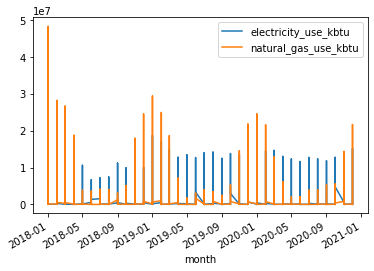

In [ ]:
res_che.set_index('month')[['electricity_use_kbtu','natural_gas_use_kbtu']].plot()

In [ ]:
data1=man_off[['month','property_id','electricity_use_kbtu']].rename({'month':'ds'},axis='columns')
#data1.set_index(data1.columns[0],inplace=True)
data2=man_off[['month','property_id','natural_gas_use_kbtu']].rename({'month':'ds'},axis='columns')
#data2.set_index(data2.columns[0],inplace=True)

In [ ]:
data1

In [ ]:
data1['Year']=data1['ds'].dt.year
data1['Month']=data1['ds'].dt.month
data2['Year']=data2['ds'].dt.year
data2['Month']=data2['ds'].dt.month
data1.head()

,ds,property_id,electricity_use_kbtu,Year,Month
22140,2018-01-01,1836480,308444.8,2018,1
22141,2018-02-01,1836480,327552.1,2018,2
22142,2018-03-01,1836480,297526.4,2018,3
22143,2018-04-01,1836480,302985.6,2018,4
22144,2018-05-01,1836480,354848.0,2018,5


In [ ]:
man_final_gas=man_off[['month','natural_gas_use_kbtu','property_id']].rename({'month':'ds','natural_gas_use_kbtu':'y'},axis='columns')
man_final=man_off[['month','electricity_use_kbtu','property_id']].rename({'month':'ds','electricity_use_kbtu':'y'},axis='columns')

In [ ]:
ids=[]
for i in man_off['property_id'].unique():
  ids.append(i)

In [ ]:
#new test
man_final_gas = man_final_gas.reset_index()


In [ ]:
man_final_gas.head()

,index,ds,y,property_id
0,22140,2018-01-01,585700.0,1836480
1,22141,2018-02-01,633699.9,1836480
2,22142,2018-03-01,573000.0,1836480
3,22143,2018-04-01,371400.0,1836480
4,22144,2018-05-01,29900.0,1836480


In [ ]:
# Group the data by ticker
groups_by_id= man_final_gas.groupby('property_id')
# Check the groups in the dataframe
groups_by_id.groups.keys()

dict_keys(['10064083', '10755135', '10791090', '10821276', '10838221', '10875704', '10876471', '10912792', '11452145', '11532799', '11609753', '11665522', '11677413', '11861912', '11982318', '12036586', '12062275', '12344501', '12344544', '12344549', '12347252', '12423644', '12428713', '12444984', '12452551', '12491084', '12926435', '14076881', '14942707', '15096497', '15283250', '15302909', '15512524', '15572905', '15620783', '15621154', '15621197', '15659169', '15747610', '16096369', '16100120', '16145600', '1836480', '1836506', '1836745', '1836866', '1836897', '2494990', '2535600', '2642783', '2652765', '2675437', '2686404', '2712458', '2734686', '2735527', '2769747', '2787165', '2792862', '2792918', '2793598', '2796992', '2813397', '2843248', '2869788', '2947149', '2966738', '3485535', '3541789', '4125415', '4407924', '4411977', '4413988', '4414000', '4414302', '4587935', '4928758', '4959515', '4959531', '4991661', '5049541', '5050269', '5050272', '5205191', '5208675', '5690409', '

In [ ]:
group['property_id'].iloc[0]

'16145600'

In [ ]:
def train_and_forecast(group):
  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)
  # Make predictions
  future = m.make_future_dataframe(periods=5)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['property_id'] = group['property_id'].iloc[0]
  forecast['y'] = group['y'].iloc[0]
  # Return the forecasted results
  return forecast[['ds', 'property_id', 'y','yhat', 'yhat_upper', 'yhat_lower']]  

In [ ]:
# Create an empty dataframe
for_loop_forecast = pd.DataFrame()
# Loop through each ticker
for ticker in ids:
  # Get the data for the ticker
  group = groups_by_id.get_group(ticker)  
  # Make forecast
  forecast = train_and_forecast(group)
  # Add the forecast results to the dataframe
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))

# Take a look at the data
for_loop_forecast.head()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr496y3ut/wfai3y3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr496y3ut/iyr363wr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37970', 'data', 'file=/tmp/tmpr496y3ut/wfai3y3q.json', 'init=/tmp/tmpr496y3ut/iyr363wr.json', 'output', 'file=/tmp/tmpr496y3ut/prophet_model5yua1qkd/prophet_model-20221012190641.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:06:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

,ds,property_id,y,yhat,yhat_upper,yhat_lower
0,2018-01-01,1836480,585700.0,407464.556185,555785.809352,270829.626968
1,2018-02-01,1836480,585700.0,580339.125948,723646.283726,441518.595478
2,2018-03-01,1836480,585700.0,575803.901782,710228.996834,437913.551469
3,2018-04-01,1836480,585700.0,311488.463066,454784.409495,163128.816952
4,2018-05-01,1836480,585700.0,83886.757377,232477.223864,-67652.213223


In [ ]:
# Get time series data for each ticker and save in a list
series = [groups_by_id.get_group(ticker) for ticker in ids]
# Create a pool process with the number of worker processes being the number of CPUs
p = Pool(cpu_count())
# Make predictions for each ticker and save the results to a list
predictions = list(tqdm(p.imap(train_and_forecast, series), total=len(series)))
# Terminate the pool process
p.close()
# Tell the pool to wait till all the jobs are finished before exit
p.join()
# Concatenate results
multiprocess_forecast = pd.concat(predictions)

  0%|          | 0/214 [00:00<?, ?it/s]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr496y3ut/cqk6t_nm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr496y3ut/erk4epbv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr496y3ut/32l2oh87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr496y3ut/4bdq00t5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33022', 'data', 'file=/tmp/tmpr49

In [ ]:
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Convert the pandas dataframe into a spark dataframe
sdf = spark.createDataFrame(man_final_gas)
# Define the restult schema
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('property_id',StringType()),
  StructField('y', DoubleType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

# Train and forecast by ticker 
spark_forecast = sdf.groupBy('property_id').applyInPandas(train_and_forecast, schema=result_schema)
# Take a look at the results
spark_forecast.show(5)


+----------+-----------+--------+----------+----------+----------+
|        ds|property_id|       y|      yhat|yhat_upper|yhat_lower|
+----------+-----------+--------+----------+----------+----------+
|2019-01-01|   10064083|206200.0| 145897.48|  264993.0|  37385.93|
|2019-02-01|   10064083|206200.0| 142052.06| 257676.77|   28850.8|
|2019-03-01|   10064083|206200.0| 138578.77|  256850.5| 22074.654|
|2019-04-01|   10064083|206200.0| 134733.33| 244178.05| 14185.042|
|2019-05-01|   10064083|206200.0|131011.945| 239720.17| 5706.9004|
+----------+-----------+--------+----------+----------+----------+
only showing top 5 rows



In [ ]:
@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def train_and_forecast(group):
  # Initiate the model
  m = Prophet(interval_width=0.95)
  
  # Fit the model
  m.fit(group)
  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['property_id'] = group['property_id'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'property_id', 'yhat', 'yhat_upper', 'yhat_lower']]  
# Start time
start_time = time()
# Train and forecast by ticker 
spark_forecast = sdf.groupBy('property_id').apply(train_and_forecast)
# Take a look at the results
spark_forecast.show(5)


+----------+-----------+----------+----------+----------+
|        ds|property_id|      yhat|yhat_upper|yhat_lower|
+----------+-----------+----------+----------+----------+
|2019-01-01|   10064083| 145897.48| 262361.47| 31059.072|
|2019-02-01|   10064083| 142052.06| 249086.77|  27514.23|
|2019-03-01|   10064083| 138578.77| 261686.55| 26633.857|
|2019-04-01|   10064083| 134733.33| 249936.39| 18774.316|
|2019-05-01|   10064083|131011.945| 249383.52|  16958.54|
+----------+-----------+----------+----------+----------+
only showing top 5 rows



In [ ]:
final_df = results.toPandas()
final_df = final_df.set_index('ds')
final_df.query('store_id == 25')[['y', 'yhat']].plot()
plt.show()

In [ ]:
final_df.query('store_id == 41')[['y', 'yhat']].plot()
plt.show()

In [ ]:
#third time

In [ ]:
#old test
ids=man_final.groupby("property_id")
ids.head(20)

,ds,y,property_id
22140,2018-01-01,308444.8,1836480
22141,2018-02-01,327552.1,1836480
22142,2018-03-01,297526.4,1836480
22143,2018-04-01,302985.6,1836480
22144,2018-05-01,354848.0,1836480
...,...,...,...
831031,2020-08-01,107297.6,16145600
831032,2020-09-01,86897.9,16145600
831033,2020-10-01,92364.1,16145600
831034,2020-11-01,88084.1,16145600


In [ ]:
#take the forecast of each building
target=pd.DataFrame()

In [ ]:
for id in ids.groups:
  group=ids.get_group(id) #have data for each building

  m=Prophet()#default 80% CI
  m.fit(group)
  future=m.make_future_dataframe(periods=13)
  forecast=m.predict(future) #yhat
  m.plot(forecast)
  forecast=forecast.rename(columns={'yhat': 'yhat_'+id})
  target=pd.merge(target, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)
  #black points actual value
  #blue line predicted value
  #blue shade id CI

In [ ]:
target

,trend_x,yhat_lower_x,yhat_upper_x,trend_lower_x,trend_upper_x,additive_terms_x,additive_terms_lower_x,additive_terms_upper_x,multiplicative_terms_x,multiplicative_terms_lower_x,...,yhat_upper_y,trend_lower_y,trend_upper_y,additive_terms_y,additive_terms_lower_y,additive_terms_upper_y,multiplicative_terms_y,multiplicative_terms_lower_y,multiplicative_terms_upper_y,yhat_9960904
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-10,57948.751160,-53858.697911,180256.734744,57948.751160,57948.751160,0.0,0.0,0.0,0.0,0.0,...,248309.956836,85599.343590,85599.343590,0.0,0.0,0.0,0.0,0.0,0.0,85599.343590
2020-12-11,57824.704987,-64267.106369,177985.373617,57824.704987,57824.704987,0.0,0.0,0.0,0.0,0.0,...,257121.282380,85587.521385,85587.521387,0.0,0.0,0.0,0.0,0.0,0.0,85587.521386
2020-12-12,57700.658813,-58074.651401,164984.248716,57700.658812,57700.658814,0.0,0.0,0.0,0.0,0.0,...,250333.094073,85575.699178,85575.699185,0.0,0.0,0.0,0.0,0.0,0.0,85575.699181


In [ ]:
target1=target[['yhat_'+id for id in ids.groups.keys()]]

In [ ]:
target1

,yhat_10064083,yhat_10755135,yhat_10791090,yhat_10821276,yhat_10838221,yhat_10875704,yhat_10876471,yhat_10912792,yhat_11452145,yhat_11532799,...,yhat_8463528,yhat_9003747,yhat_9005293,yhat_9498587,yhat_9498640,yhat_9544694,yhat_9666217,yhat_9666218,yhat_9666221,yhat_9960904
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,89179.872546,266464.741192,247050.513600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58711.067402,230042.081114,177121.166001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47435.870962,218780.105995,164608.615366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21795.614901,158813.212951,100254.107504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8082.761614,108880.943236,37693.408360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-10,57948.751160,71703.437295,205217.069092,77707.079813,19813.728450,112880.863114,0.0,137567.442979,18103.695636,160857.324053,...,-80106.855717,-318379.296207,-212072.383691,193399.931558,100414.835276,465781.306229,51044.917577,135887.126914,NaN,85599.343590
2020-12-11,57824.704987,71544.380199,204337.837782,77879.461332,19798.677809,112742.913268,0.0,137538.241796,17636.607926,160197.661981,...,-95789.724473,-379465.237550,-255385.040178,192172.478261,99433.705762,465199.512343,50949.654073,135836.042385,NaN,85587.521386
2020-12-12,57700.658813,71385.323104,203458.606473,78051.842850,19783.627168,112604.963422,0.0,137509.040612,17169.520217,159537.999908,...,-110564.836559,-436839.058728,-296379.451009,190945.024964,98452.576247,464617.718457,50854.390569,135784.957856,NaN,85575.699181


In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values_table(target1)

Your selected dataframe has 214 columns.
There are 214 columns that have missing values.


,Missing Values,% of Total Values
yhat_6692902,54,72.0
yhat_16096369,50,66.7
yhat_15621197,50,66.7
yhat_14076881,50,66.7
yhat_14942707,50,66.7
...,...,...
yhat_2796992,26,34.7
yhat_2813397,26,34.7
yhat_6311001,26,34.7
yhat_2966738,26,34.7


In [ ]:
man_final.head(20)

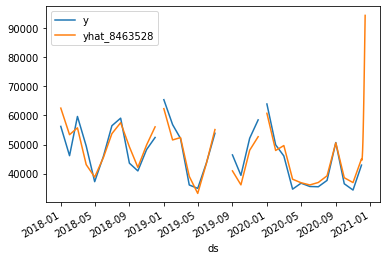

In [ ]:
pd.concat([man_final.set_index('ds').query("property_id=='8463528'")['y'],target['yhat_8463528']],axis=1).plot()

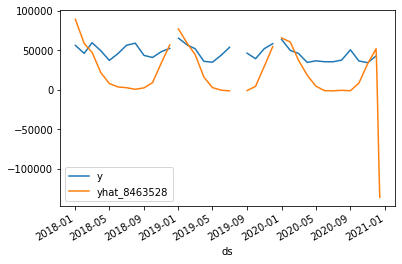

In [ ]:
pd.concat([man_final.set_index('ds').query("property_id=='8463528'")['y'],target['yhat_8463528']],axis=1).plot()

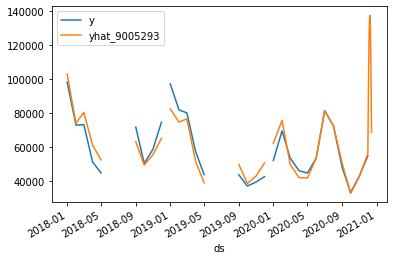

In [ ]:
pd.concat([man_final.set_index('ds').query("property_id=='9005293'")['y'],target['yhat_9005293']],axis=1).plot()

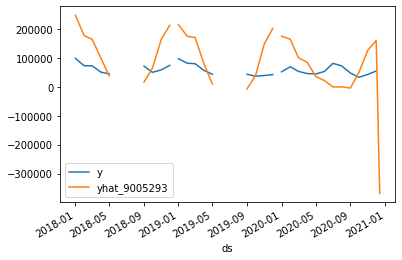

In [ ]:
pd.concat([man_final.set_index('ds').query("property_id=='9005293'")['y'],target['yhat_9005293']],axis=1).plot()

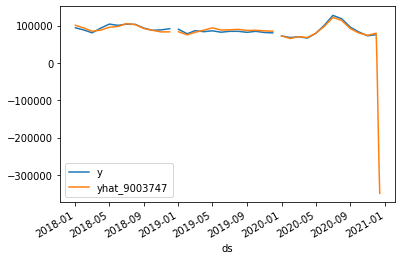

In [ ]:
pd.concat([man_final.set_index('ds').query("property_id=='9003747'")['y'],target['yhat_9003747']],axis=1).plot()

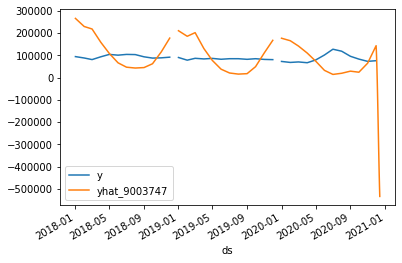

In [ ]:
pd.concat([man_final.set_index('ds').query("property_id=='9003747'")['y'],target['yhat_9003747']],axis=1).plot()

In [ ]:

def run_prophet(timeserie):
    model = Prophet(yearly_seasonality=False,daily_seasonality=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=90, include_history=False)
    forecast = model.predict(forecast)
    return forecast

ModuleNotFoundError: ignored

In [ ]:
f = run_prophet(melt_elect[2])
f.head()

KeyError: ignored

In [ ]:
melt_elect[2]

KeyError: ignored